# Regex Model Development Notebook
Goal of this notebook is to figure out a good starter regex to use for a simple model. Will need to see how well a bunch of different individual and combinations of regex patterns work. Primary evaluation metric will be accuracy. Will utilize the balanced cardiac arrest DC summary dataset to facilitate interpretation.

## Imports

In [18]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import ipywidgets as widgets
import string
import nltk
import functools
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import itertools

### Read DF

In [19]:
df = pd.read_csv(Path('../data/test_parse_output.csv'), header=None, names=['dc_summary','code'])

### Preprocess text
- remove punctuation
- remove digits
- all lower
- keep stopwords
- Convert
    - CPR to 'cardiopulmonary resuscitation'
    - PEA to 'pulseless electrical activity'
    - ROSC to 'return of spontaneous circulation'
    - ACLS to 'advanced cardiac life support'
    - VT to 'ventricular tachycardia'
    - VF to 'ventricular fibrillation'
    - VT/VF to 'ventricular fibrillation'

In [20]:
def remove_digits(text):
    return ''.join([c for c in text if not c.isdigit()]).lower()

def remove_punctuation(text):
    return re.sub('[' + re.escape(string.punctuation) + r'\\\n]', ' ', text)

def fix_acronyms(text):
    acronyms = {
        'cpr'   : 'cardiopulmonary resuscitation',
        'pea'   : 'pulseless electrical activity',
        'rosc'  : 'return of spontaneous circulation',
        'acls'  : 'advanced cardiac life support',
        'vf'    : 'ventricular fibrillation',
        'vfib'  : 'ventricular fibrillation',
        'vt'    : 'ventricular tachycardia',
        'vtvf'  : 'ventricular fibrillation',
        'vfvt'  : 'ventricular fibrillation'}

    text = [acronyms[w] if w in acronyms else w for w in text.split()]
    return ' '.join(text)

def _compose(*functions):
    return functools.reduce(lambda f, g: lambda x: g(f(x)), functions)  

composed_fn = _compose(
    remove_digits,
    remove_punctuation,
    fix_acronyms
)

In [21]:
df['post_dc_summary']= df.dc_summary.apply(composed_fn)
    

### Regex from Single Keyword

In [22]:
pattern = re.compile(r'cardiopulmonary resuscitation')

In [23]:
df['preds'] = df.post_dc_summary.str.contains(pattern)

In [25]:
accuracy_score(df.code, df.preds)

0.6643414033647927

In [26]:
confusion_matrix(df.code, df.preds)

array([[1177,   18],
       [ 800,  442]], dtype=int64)

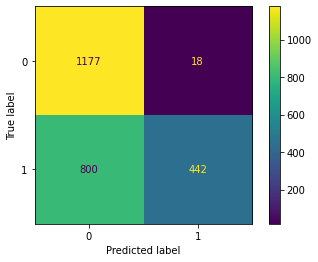

In [27]:
ConfusionMatrixDisplay(confusion_matrix(df.code, df.preds)).plot()

#### Test statistic functions

In [28]:
def PPV(cm):
    #TP / (TP + FP)
    TP = cm[1][1]
    FP = cm[0][1]
    return TP / (TP + FP)
def sens(cm):
    #TP / (TP + TN)
    TP = cm[1][1]
    TN = cm[0][0]
    return TP / (TP + TN)
def spec(cm):
    #TN / (TN + FP)
    TN = cm[0][0]
    FP = cm[0][1]
    return TN / (TN + FP)
def accuracy(cm):
    #TP + TN / FP + FN
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    return (TP + TN) / (FP + FN + TP + TN)


In [29]:
cm = confusion_matrix(df.code, df.preds)
print(f'PPV: {PPV(cm)}')
print(f'sens: {sens(cm)}')
print(f'spec: {spec(cm)}')
print(f'accuracy: {accuracy(cm)}')


PPV: 0.9608695652173913
sens: 0.2730080296479308
spec: 0.9849372384937238
accuracy: 0.6643414033647927


### Test with many individual keywords

In [30]:
keywords = [
    r'cardiopulmonary resuscitation',
    r'pulseless electrical activity',
    r'return of spontaneous circulation',
    r'advanced cardiac life support',
    r'ventricular fibrillation',
    r'ventricular tachycardia'
]

In [33]:
def keyword_stats(df, keyword):
    #input df must have columns of ['post_dc_summary','code']
    #return pd.Series object
    #index = [keyword, sens, spec, ppv, accuracy]
    pattern = pattern = re.compile(keyword)
    df = df[['post_dc_summary','code']].copy() #avoid scope issues
    df['preds'] = df.post_dc_summary.str.contains(pattern)
    cm = confusion_matrix(df.code, df.preds)
    return pd.Series(
        data=[keyword, sens(cm), spec(cm), PPV(cm), accuracy(cm)], 
        index=['keyword','sens','spec','PPV','accuracy'])


In [34]:
pd.DataFrame([keyword_stats(df, k) for k in keywords])


,keyword,sens,spec,PPV,accuracy
0,cardiopulmonary resuscitation,0.273008,0.984937,0.960870,0.664341
1,pulseless electrical activity,0.255238,0.981590,0.948113,0.646286
2,return of spontaneous circulation,0.060726,0.996653,0.950617,0.520312
3,advanced cardiac life support,0.075486,0.994142,0.932692,0.527288
4,ventricular fibrillation,0.179219,0.984937,0.934545,0.588428
5,ventricular tachycardia,0.175872,0.948954,0.798680,0.564629


### Test with combinations

In [35]:
keywords = [
    r'cardiopulmonary resuscitation',
    r'pulseless electrical activity',
    r'return of spontaneous circulation',
    r'advanced cardiac life support',
    r'ventricular fibrillation',
    r'ventricular tachycardia'
]

In [36]:
def make_pattern(multiple_keywords):
    p = r''
    for s in multiple_keywords:
        p = p + s + '|'
    return p[:-1]

s = []
for i in range(1,len(keywords)+1):
    for c in itertools.combinations(keywords, i):
        s.append(make_pattern(c))



In [37]:
combined_stats = pd.DataFrame([keyword_stats(df, k) for k in s])

In [40]:
combined_stats.sort_values(by='PPV', ascending=False)

,keyword,sens,spec,PPV,accuracy
0,cardiopulmonary resuscitation,0.273008,0.984937,0.960870,0.664341
7,cardiopulmonary resuscitation|return of sponta...,0.283973,0.983264,0.958848,0.673369
25,cardiopulmonary resuscitation|return of sponta...,0.305276,0.980753,0.957249,0.692245
8,cardiopulmonary resuscitation|advanced cardiac...,0.295673,0.980753,0.955340,0.682807
15,return of spontaneous circulation|advanced car...,0.123338,0.993305,0.954286,0.555601
...,...,...,...,...,...
20,ventricular fibrillation|ventricular tachycardia,0.261639,0.942259,0.852564,0.625769
38,return of spontaneous circulation|advanced car...,0.247664,0.943096,0.845103,0.614690
19,advanced cardiac life support|ventricular tach...,0.220456,0.943933,0.826425,0.593763
17,return of spontaneous circulation|ventricular ...,0.207983,0.946444,0.822715,0.585966


### Review False Negatives from all keywords regex pattern

In [42]:
pattern = make_pattern(keywords)
df['preds'] = df.post_dc_summary.str.contains(pattern)

In [46]:
cm = confusion_matrix(df.code, df.preds)
print(f'Accuracy of the full pattern is: {accuracy(cm)}')

Accuracy of the full pattern is: 0.7894952810832991


#### FN Review notes 
1) false code indication, pred seems true actually
2) same as  1
3) same as 1
4) 'asystolic arrest'
5) 'chest compressions', 'cardiac arrest'
6) 'coded' + something is going on with the hospital course that is causing it to end pattern at r'[**Initial' not sure if this is just the end of the hospital course, or if something unwanted is happening here.
7) 'Fenard Intensive Care Unit' in hospital course identifies the hospital, need to report this. Also, looks like it captured the past medical history of myocardial infarction. I suppose I could capture that with 'myocardial infarction'
8) looks like hosptail course may have been truncated? 
9) 'chest compressions', 'asystole'
10) CPR was reported after the patient was comfort care... I think this will always be a false positive.
11) not sure where the cardiac arrest diagnosis came from, patient made CMO and palliatively extubated